# Подготовка обучающей выборки

### Описание шагов: 

1. Все flac аудиозаписи из трех источников (train-clean-100, train-clean-360) записыаются в файл формата h5py.

Было решено использовать файлы только из двух источников, и не использовать датасет train-clean-500, потому что 460 достаоочно для бейзлайновой модели, а обработка ауодиофайлов занимает достаточно долгое время.

2. Расчитывается суммарная длинна всех аудиозаписией, а затем расчитывается кол-во фреймов, на которые эта аудиозапись будет разделена. Размер одного фрейма равен 10 мс. Каждую аудиозапись падим так, чтобы она билась на ровное кол-во фреймов без остатка.

3. Полученные фреймы прогоняем через предобученную модель webrtcvad (mode = 0) и получаем разметку.


        0 - речь на фрейме отсутсвует
        1 - на айдио фрейме присутсвует речь
        
    
5. Добавляем тишину. Для лейбла 0 добавляем тишину рандомной длительностью. 

6. Дабавляем шум из подготовленных данных. Датасет с шумом был взят из репозитория [QUT-NOISE](https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/). Путем добавления шума мы делаем данные похожие на реальные. Подготовка данных реализована в отдельной ноутбуке: 1.1.Noise_preprocessing. Из данных был удален шум из кафы и жилой комнаты, потому что там встречается речь.

7. Достаем фичи: MFCC + delta

В качестве фичей было решено использовать MFCC коэфициенты и их delta. Их достаточно просто расчитывать и хранить, а информации, которая в них содержиться, достаточно для обучения модели

In [1]:
import os
path_peer = 'LibriSpeech/'
is_peer = os.path.exists(path_peer)

if is_peer:
    os.chdir(path_peer)

print('Directory is set to', os.getcwd())

Directory is set to /home/eva/eva_project_dir/VAD/LibriSpeech


In [2]:
import pandas as pd
import numpy as np

import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from function import * 

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import h5py_cache
import webrtcvad
import python_speech_features


Для проверки данных прослушаем несколько рандомных примеров из датасета

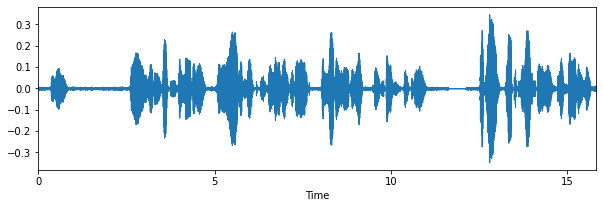

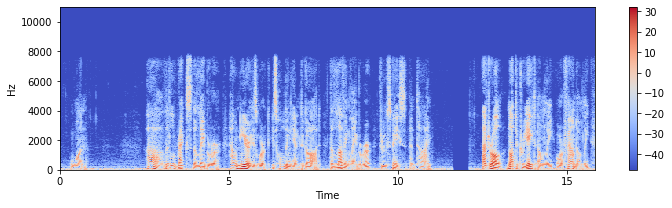

In [4]:
path = 'train-clean-360/1001/134707/1001-134707-0000.flac'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
#create_spectrogram(data, sampling_rate)
#create_M_spect(data, sampling_rate, 30)
Audio(path)

### Информация о формате данных и обработке 

Данные из датасета Librispeech хранятся в формате flac (16kHz, one channel). Они представляют собой записи голоса различных дикторов, читающих текст книги на английском. В ходе данного решения эти данные будут обработаны по следующей схеме: 
* все данные будут смерджены в одну запись, а затем разбиты на фреймы по 10 секунд. 
* затем помощью предобученый модели из фреймворка WebRTCVad будут найдены лейблы: 0 - если на записи нет голоса человека, 1 - если голос присутсвует. 
* добавление тишины и соответсвующих таймкоду лейблов 0
* добавление шума, чтобы данные были приближены к реальным данным 

In [5]:
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# Размер фрейма в милисекундах 
FRAME_SIZE_MS = 10

# Расчитываем размер фрейма в формате вектора
FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))

In [5]:
data = h5py.File('data_train.hdf5', 'a')

In [6]:
files = glob.glob('./train-clean-100/' + '/**/*.flac', recursive=True)
#files.extend(glob.glob('./train-clean-360/' + '/**/*.flac', recursive=True))
#files.extend(glob.glob('./train-other-500/' + '/**/*.flac', recursive=True))

files = [f for f in files]

#Выделяем пространство для датасета с путями файлов
dt = h5py.special_dtype(vlen=str)
data.create_dataset('files', (len(files),), dtype=dt)

<HDF5 dataset "files": shape (28539,), type "|O">

In [7]:
#Записываем пути файлов 
for i, f in enumerate(files):
    data['files'][i] = f

In [8]:
#проверяем, что записалось все верно
data['files'][0]

b'./train-clean-100/887/123291/887-123291-0035.flac'

### Достаем каждый файл по его пути, конвентируем и сохраняем

In [5]:
def get_track_count():
    return len(data['files'])

In [10]:
#Конвентируем аудиофайлы в нужный формат 
#Сохраняем каждый файл в отдельный датасет 'audio_raw'

progress = 1
# Создаем пространство для адуио в формате int16! Такой формат необходим для WebRTCVAD
if 'audio_raw' not in data:
    dt = h5py.special_dtype(vlen=np.dtype(np.int16))
    data.create_dataset('audio_raw', (get_track_count(),), dtype=dt)

for i, file in enumerate(data['files']): 
    print('Processing {0} of {1}'.format(progress, get_track_count()), end='\r', flush=True)
    progress += 1
    # Проверяем сконвертировано ли уже аудио
    if len(data['audio_raw'][i]) > 0:
        continue

    track = (AudioSegment.from_file(file)
             .set_frame_rate(SAMPLE_RATE)
             .set_sample_width(SAMPLE_WIDTH)
             .set_channels(SAMPLE_CHANNELS))

    data['audio_raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)

In [11]:
#проверяем, что все записалось верно и с форматом int16
data['audio_raw'][0]

array([ -67,  -74,  -55, ...,    6,  -84, -118], dtype=int16)

### Соединяем все записи в одну и разбиваем на фреймы 

Размер одного фрейма равен 10 мс. Такой размер был выбран, чтобы модель обучалась и валидировалась на одинковом размере фрейма. Каждую аудиозапись падим так, чтобы она билась на ровное кол-во фреймов без остатка.


In [12]:
%%time
frame_count = 0
progress = 1

# Вычисляем кол-во итоговых фреймов, которые получаются из всех записей, смердженных вместе
for raw in data['audio_raw']:
    frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
    print('Counting frames ({0} of {1})'.format(progress, get_track_count()), end='\r', flush=True)
    progress += 1

# Создаем датасет необходимого размера для хранения фреймов: кол-во фреймов, размер одного фрейма
dt = np.dtype(np.int16)
data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)

progress = 0

# Buffer to speed up merging as HDF5 is not fast with lots of indexing.
buffer = np.array([])
buffer_limit = FRAME_SIZE * 4096

# Merge frames.
for raw in data['audio_raw']:

    # Добавляем паддинг, чтобы каждая запись разбивалась на фреймы без остатка
    raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))

    # Add to buffer.
    buffer = np.concatenate((buffer, raw))

    # If buffer is not filled up and we are not done, keep filling the buffer up.
    if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
        continue

    # Получаем фреймы
    frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
    buffer = np.array([])

    # Добавляем фреймы 
    data['frames'][progress : progress + len(frames)] = frames

    progress += len(frames)
    print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)

CPU times: user 3min 24s, sys: 32.6 s, total: 3min 56s
Wall time: 7min 49s


### Предсказываем лейблы на полученном датасете

Для каждого десятисекундого фрейма делаем предсказание с помощью webrtcvad (mode = 0). 

* 0 - речь на фрейме отсутсвует
* 1 - на айдио фрейме присутсвует речь 

In [13]:
%%time
vad = webrtcvad.Vad(0)

frame_count = len(data['frames'])
progress = 0
batch_size = 65536

# Create data set for labels.
dt = np.dtype(np.uint8)
data.create_dataset('labels_new', (frame_count,), dtype=dt)

# Label all the frames.
for pos in range(0, frame_count, batch_size):

    frames = data['frames'][pos : pos + batch_size]
    labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
    data['labels_new'][pos : pos + batch_size] = np.array(labels)

    progress += len(labels)
    print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)



CPU times: user 1min 41s, sys: 4.03 s, total: 1min 45s
Wall time: 3min 5s


### Добавление шума 

Для того, чтобы получить более реальные данные добавляем шум  

In [6]:
# Min/max length for slicing the voice files.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Convert slice ms to frame size.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

In [7]:
import array

In [8]:
speech_data = h5py_cache.File('data_train.hdf5', 'a', chunk_cache_mem_size=1024**3)
#noise_data = h5py_cache.File('data_noise.hdf5', 'a', chunk_cache_mem_size=1024**3)
noise_data = h5py.File('data_noise.hdf5', 'r')
#noise_levels_db = { 'None': None, '-15': -15, '-3': -3 }
noise_levels_db = {'-3': -3 }

mfcc_window_frame_size = 4


np.random.seed(1337)

def add_noise(speech_frames, noise_frames, align_frames, noise_level_db):
    
    # Convert to tracks.
    speech_track = (AudioSegment(data=array.array('h', speech_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    noise_track = (AudioSegment(data=array.array('h', noise_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    # Overlay noise.
    track = noise_track.overlay(speech_track, gain_during_overlay=noise_level_db)

    # Get frames data from track.
    raw = np.array(track.get_array_of_samples(), dtype=np.int16)
    frames = np.array(np.split(raw, len(raw) / FRAME_SIZE))
    
    # Add previous frames to align MFCC window.
    frames_aligned = np.concatenate((align_frames, frames))
    
    mfcc = python_speech_features.mfcc(frames_aligned, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    # First MFCC feature is just the DC offset.
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    
    return frames, mfcc, delta

### Добавление рандомно тишины

In [9]:
pos = 0
l = len(speech_data['frames'])
slices = []

# Делим аудиозапись на слайсы рандомной длины
while pos + SLICE_MIN < l: 
    #генерируем индкексы начала и конца слайса (длина в пределах SLICE_MIN, SLICE_MAX)
    slice_indexing = (pos, pos + np.random.randint(SLICE_MIN, SLICE_MAX + 1))
    #Сохраняем индексы начала и конца слайсов
    slices.append(slice_indexing)
    #пермещаем индекс позиции на конец индекса текущего слайса
    pos = slice_indexing[1]

# Add remainder to last slice.
slices[-1] = (slices[-1][0], l)

In [10]:
pos = 0

# Добавляем рандомно тишину в пределах длины слайса
while pos + SLICE_MIN < l:
    #генерируем длину как на предыдущем шаге
    length = np.random.randint(SLICE_MIN, SLICE_MAX + 1)
    slice_indexing = (length, length)
    slices.append(slice_indexing)
    #пермещаем индекс на полученную длину 
    pos += length

# Общее количество фреймов
total = l + pos + mfcc_window_frame_size

In [18]:
data = h5py.File('features.hdf5', 'a')

In [19]:
# Пермешиваем рандомно слайсы
np.random.shuffle(slices)

# Создаем новые соотвествующие датасеты с учетом разного добавления шума
for key in noise_levels_db:
    data.create_dataset('frames-' + key, (total, FRAME_SIZE), dtype=np.dtype(np.int16))
    data.create_dataset('mfcc-' + key, (total, 12), dtype=np.dtype(np.float32))
    data.create_dataset('delta-' + key, (total, 12), dtype=np.dtype(np.float32))

# Создаем датасет для лейблов
dt = np.dtype(np.int8)
data.create_dataset('labels', (total,), dtype=dt)

pos = 0


In [20]:
data.keys()

<KeysViewHDF5 ['delta--3', 'frames--3', 'labels', 'mfcc--3']>

In [21]:
speech_data.keys()

<KeysViewHDF5 ['audio_raw', 'files', 'frames', 'labels_new']>

### Генерация обучающей выборки

In [22]:
for s in slices:

    # Если индексы начала и конца слайса равны, то "заполняем" фрейм тишиной и ставим соответсвующий лейбл 0
    if s[0] == s[1]:
        frames = np.zeros((s[0], FRAME_SIZE))
        labels = np.zeros(s[0])
    # Если нет, то используем данные с голосом
    else:
        frames = speech_data['frames'][s[0] : s[1]]
        labels = speech_data['labels_new'][s[0] : s[1]]

    # Выбираем рандомно фрейм с шумом
    i = np.random.randint(0, len(noise_data['frames']) - len(labels))
    noise = noise_data['frames'][i : i + len(labels)]

    # Устанавливаем уровень шума: None, -15dB, -3dB
    for key in noise_levels_db:

        # Добавляем выравнимае фреймов
        if pos == 0:
            align_frames = np.zeros((mfcc_window_frame_size - 1, FRAME_SIZE))
        else:
            align_frames = data['frames-' + key][pos - mfcc_window_frame_size + 1 : pos]

        # Добавляем шум и получаем фреймы, MFCC и дельты MFCC.
        frames, mfcc, delta = add_noise(np.int16(frames), np.int16(noise), 
                                        np.int16(align_frames), noise_levels_db[key])
        # Записываем в соответсвующие датасеты
        data['frames-' + key][pos : pos + len(labels)] = frames
        data['mfcc-' + key][pos : pos + len(labels)] = mfcc
        data['delta-' + key][pos : pos + len(labels)] = delta

    # Добавляем лейблы
    data['labels'][pos : pos + len(labels)] = labels

    pos += len(labels)
    print('Generating data ({0:.2f} %)'.format((pos * 100) / total), end='\r', flush=True)



In [36]:
data.close()